<a href="https://colab.research.google.com/github/deepsharma26/SIRT1_Main/blob/Data_spliting_and_Feature_selection/SIRT1_data_splitting__and_feature_selection_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SIRT1 data splitting and feature selection
#Feature slection
Remove low-variance features and highly correlated features.
Normalization using Z-score

In [47]:
#loading moduels
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

In [48]:
# List of different descriptor files file names (modify accordingly)
file_names = [
     "/content/AtomPairs2D.csv", "/content/AtomPairs2DCount.csv", "/content/CDKextended.csv", "/content/CDKgraphonly.csv", "/content/EState.csv", "/content/KlekotaRoth.csv", "/content/KlekotaRothCount.csv", "/content/MACCS.csv", "/content/PubChem.csv", "/content/RDkit_descriptors.csv", "/content/Substructure.csv", "/content/SubstructureCount.csv", "/content/X_and_Y.csv", "/content/Modified_molecules_with_morganfingerprints.csv"
]

# Process each file
for file in file_names:
    print(f"Processing {file}...")

    # Load dataset
    df = pd.read_csv(file)

    # Step 1: Remove non-descriptor columns
    X = df.drop(columns=['Name', 'Class'], errors='ignore')  # molecule_chembl_id=name

    # Step 2: Remove low-variance features
    # Replace infinite values with NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    # Drop rows with any NaN values
    X = X.dropna()

    var_thresh = VarianceThreshold(threshold=0.1)
    X_var = var_thresh.fit_transform(X)
    selected_columns = X.columns[var_thresh.get_support()]
    X = pd.DataFrame(X_var, columns=selected_columns)

    # Step 3: Remove highly correlated features
    corr_matrix = X.corr()
    correlated_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.9:
                correlated_features.add(corr_matrix.columns[i])

    X = X.drop(columns=correlated_features, errors='ignore')



    # Save the processed dataset
    directory, filename = os.path.split(file)
    output_file = os.path.join(directory, f"processed_{filename}")
    X.to_csv(output_file, index=False)
    print(f"Saved processed file as {output_file}")


Processing /content/AtomPairs2D.csv...
Saved processed file as /content/processed_AtomPairs2D.csv
Processing /content/AtomPairs2DCount.csv...
Saved processed file as /content/processed_AtomPairs2DCount.csv
Processing /content/CDKextended.csv...
Saved processed file as /content/processed_CDKextended.csv
Processing /content/CDKgraphonly.csv...
Saved processed file as /content/processed_CDKgraphonly.csv
Processing /content/EState.csv...
Saved processed file as /content/processed_EState.csv
Processing /content/KlekotaRoth.csv...
Saved processed file as /content/processed_KlekotaRoth.csv
Processing /content/KlekotaRothCount.csv...
Saved processed file as /content/processed_KlekotaRothCount.csv
Processing /content/MACCS.csv...
Saved processed file as /content/processed_MACCS.csv
Processing /content/PubChem.csv...
Saved processed file as /content/processed_PubChem.csv
Processing /content/RDkit_descriptors.csv...
Saved processed file as /content/processed_RDkit_descriptors.csv
Processing /cont

Merging of processed descritpors files (Have lesser number descriptors than the original created files)

In [49]:
# List of processed descriptor file names
processed_files = [
    "/content/processed_AtomPairs2D.csv",
    "/content/processed_AtomPairs2DCount.csv",
    "/content/processed_CDKextended.csv",
    "/content/processed_CDKgraphonly.csv",
    "/content/processed_EState.csv",
    "/content/processed_KlekotaRoth.csv",
    "/content/processed_KlekotaRothCount.csv",
    "/content/processed_MACCS.csv",
    "/content/processed_PubChem.csv",
    "/content/processed_RDkit_descriptors.csv",
    "/content/processed_Substructure.csv",
    "/content/processed_SubstructureCount.csv",
    "/content/processed_X_and_Y.csv",
    "/content/processed_Modified_molecules_with_morganfingerprints.csv"
]

# Load and merge all files
merged_df = pd.concat([pd.read_csv(file) for file in processed_files], axis=1)

# Save the merged dataset
output_file = "/content/merged_descriptors.csv"
merged_df.to_csv(output_file, index=False)

print(f"Merged dataset saved as: {output_file}")


Merged dataset saved as: /content/merged_descriptors.csv


#Determine Optimal Number of Clusters (Elbow Method & Silhouette Score)

Principal Component Analysis (PCA) was used to improve clustering performance by reducing the dimensionality of the dataset.
The Elbow Method helps determine the optimal number of clusters by plotting inertia (within-cluster sum of squares) vs. the number of clusters (k). The goal is to find the "elbow point" where adding more clusters does not significantly reduce inertia anymore.
The silhouette score gives a quantitative measure of how well-separated the clusters are.
Interpretation:
Choose the k with the highest silhouette score.
Typically, a silhouette score > 0.5 is good, while >0.7 is excellent

PCA applied, clustering results saved.


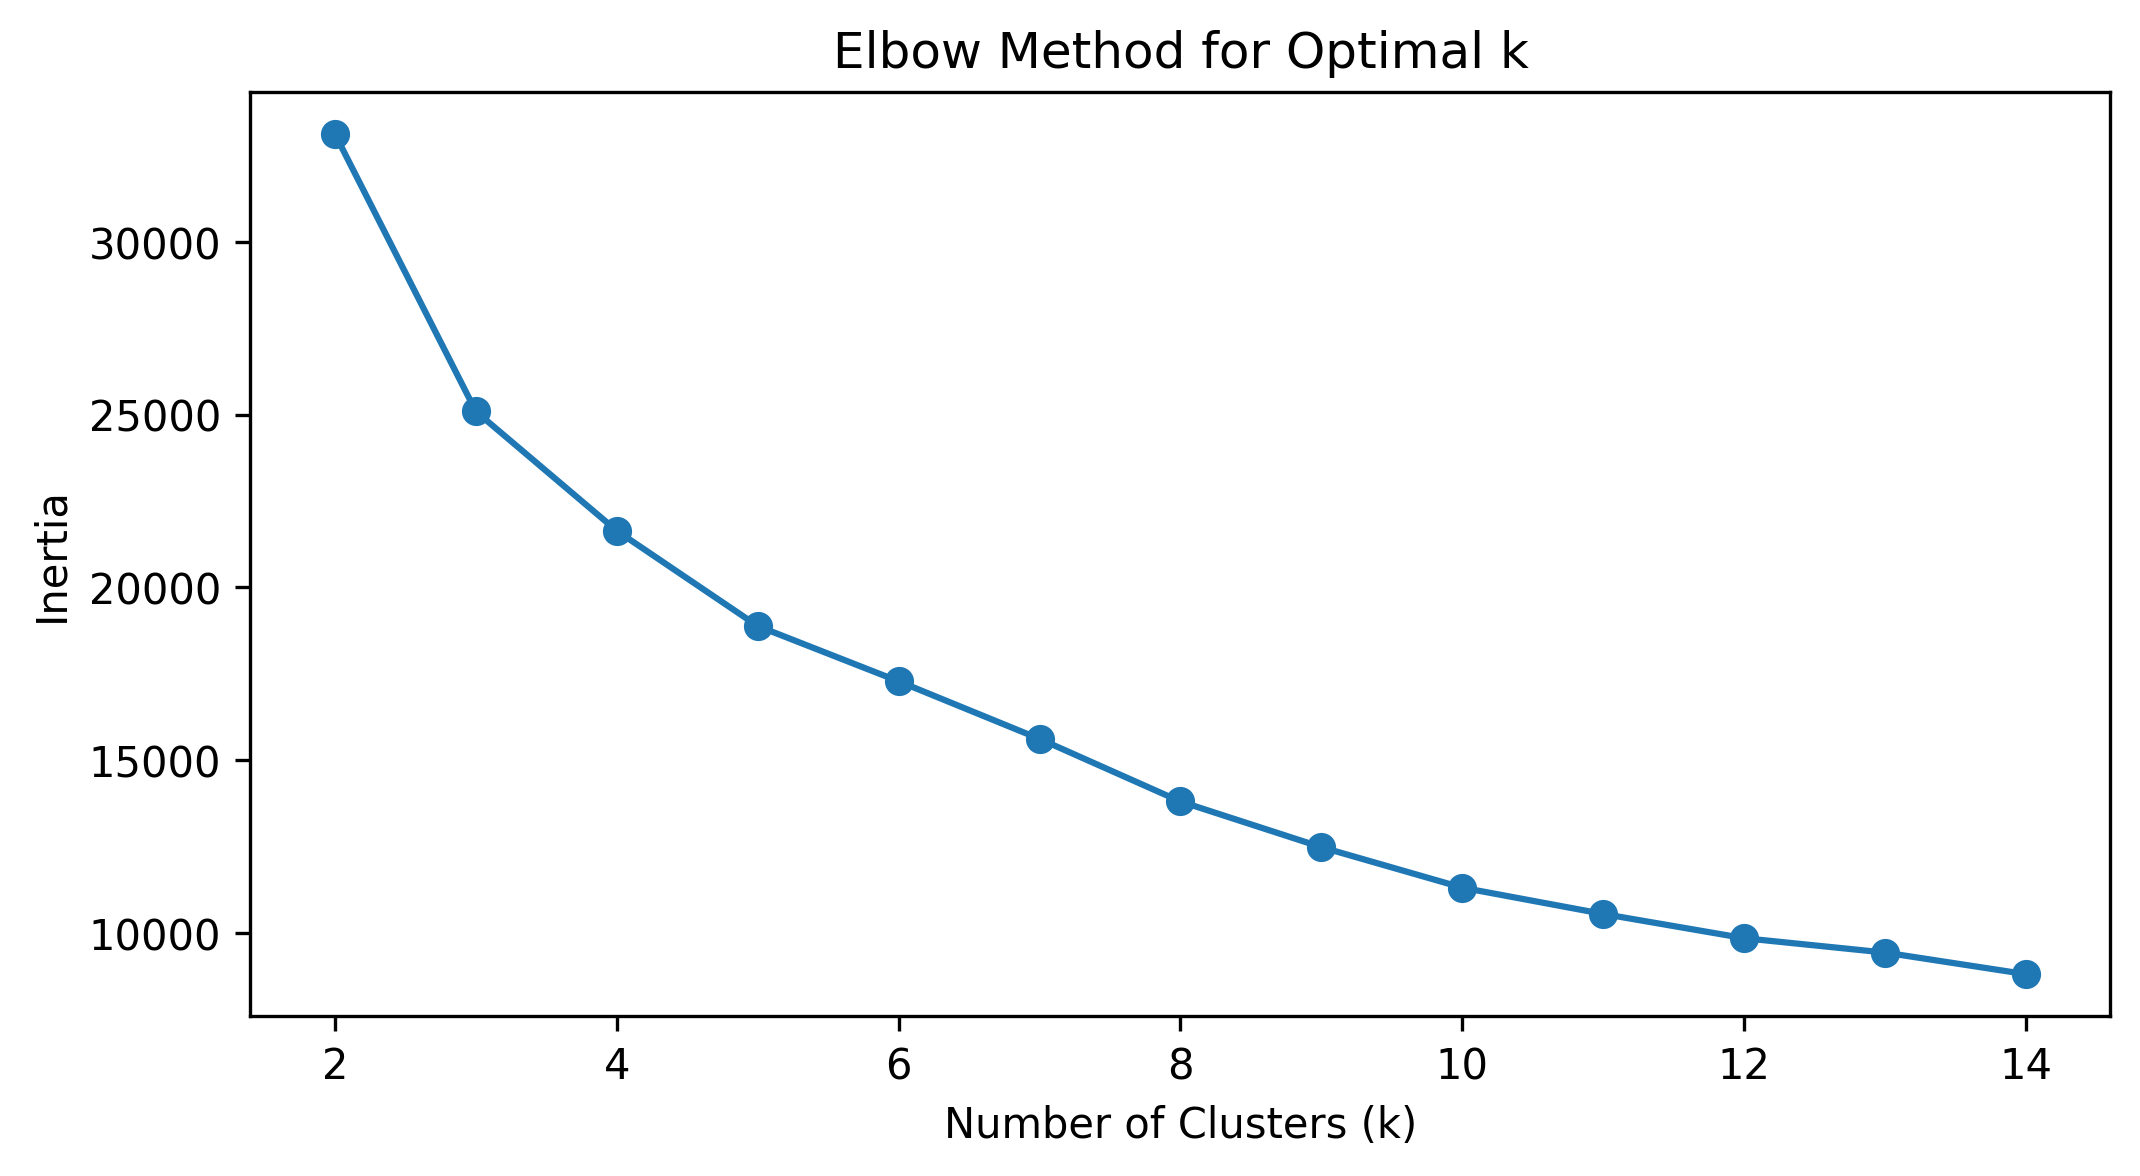

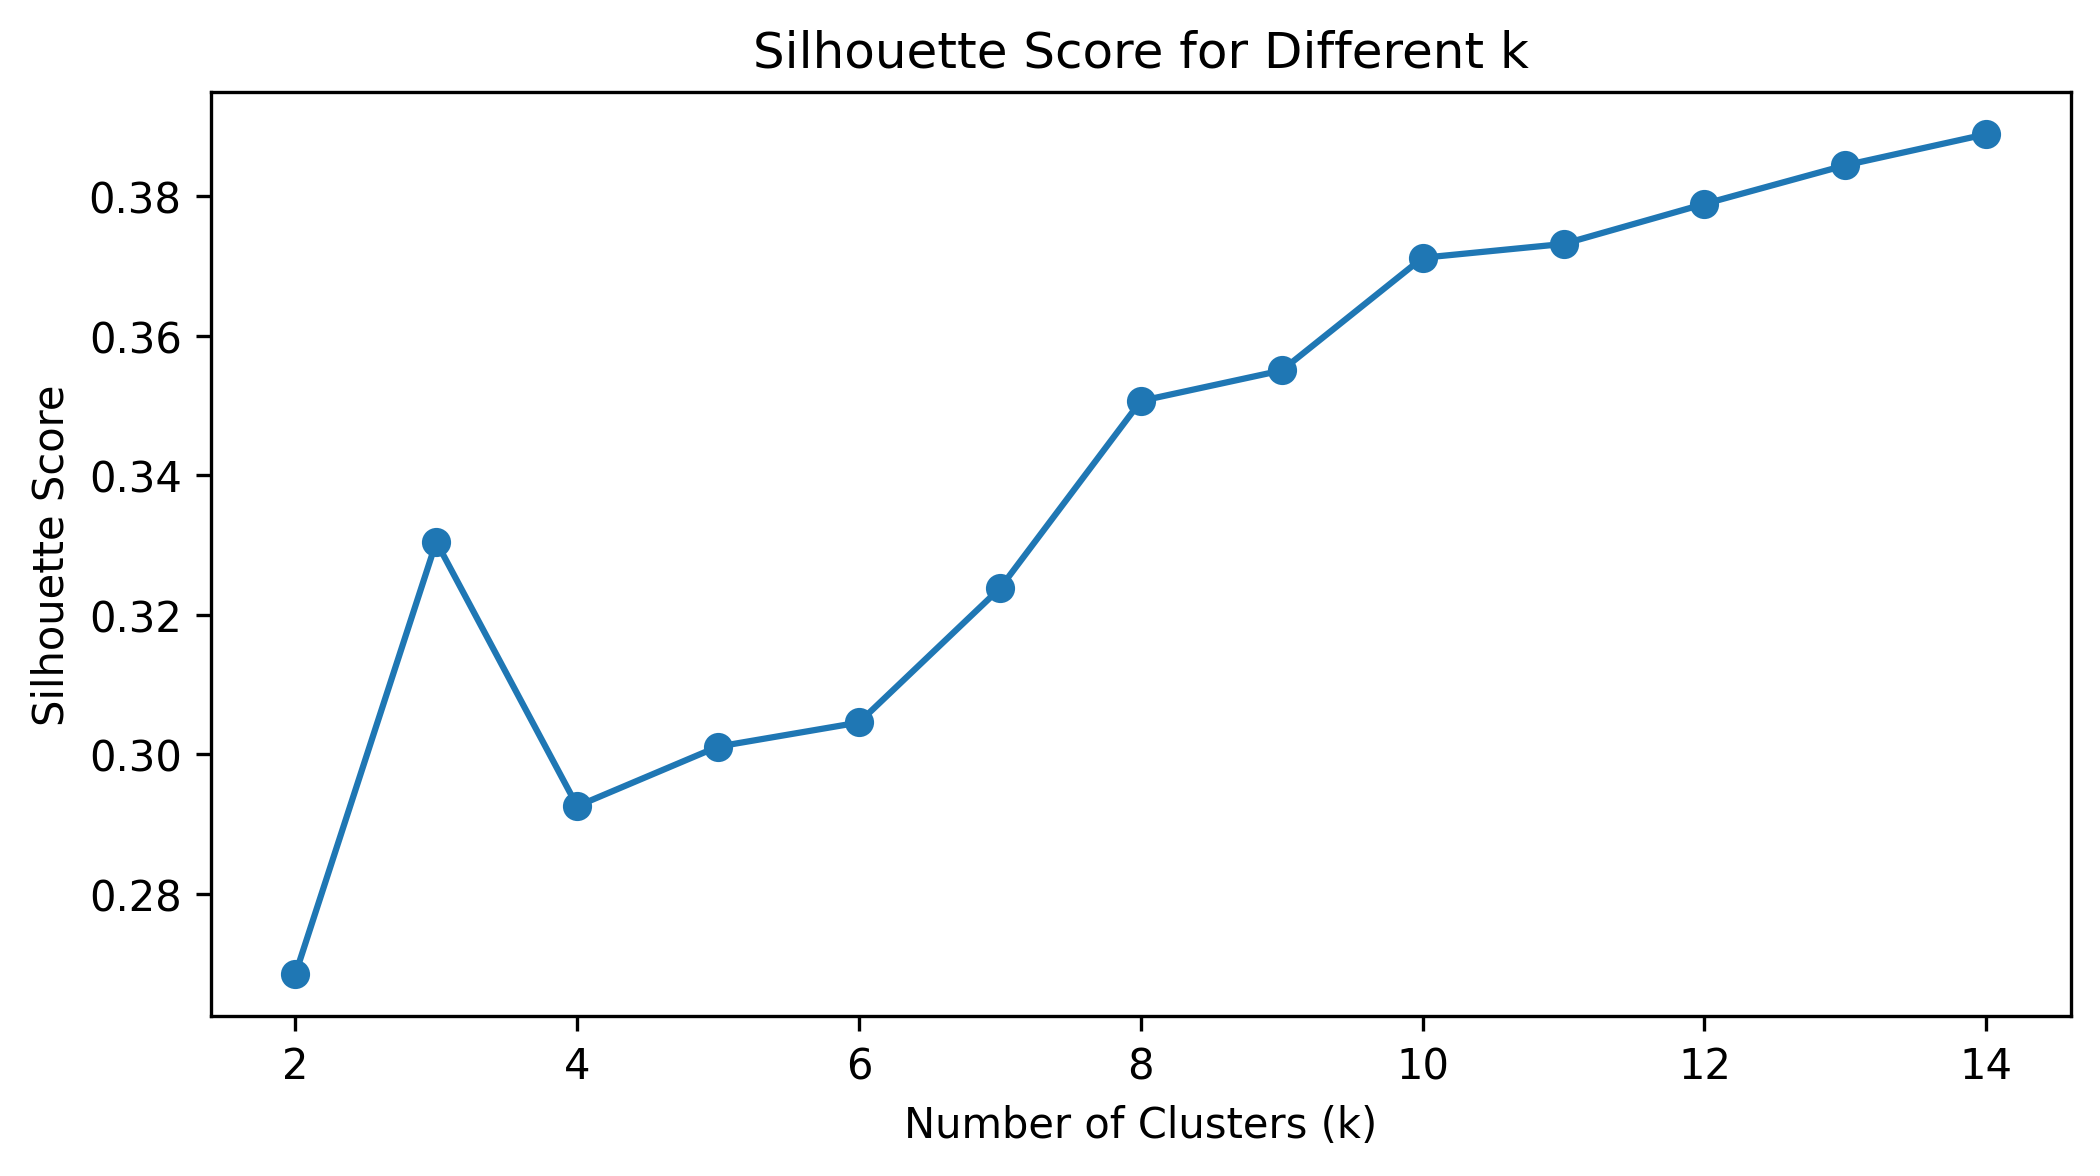

In [50]:
# Load dataset
df = pd.read_csv("/content/merged_descriptors.csv")

# Standardize features (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Before applying PCA, impute or remove NaN values if present
X_scaled = np.nan_to_num(X_scaled) # Replace NaN with 0

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Reduce to 10 components
X_pca = pca.fit_transform(X_scaled)

# Save PCA-transformed data (Optional)
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(10)])
pca_df.to_csv("PCA_transformed_data.csv", index=False)

# Determine Optimal Number of Clusters (Elbow Method & Silhouette Score)
inertia = []
silhouette_scores = []
cluster_range = range(2, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)  # Use PCA-transformed data
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.rcParams['figure.dpi'] = 300
plt.savefig('Elbow_Method_for_Optimal_k.jpeg', dpi=300)

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k")
plt.rcParams['figure.dpi'] = 300
plt.savefig('Silhouette_Score.jpeg', dpi=300)

print("PCA applied, clustering results saved.")

#Check Cluster Balance
After choosing k, check if clusters are well-distributed and not too small or large.

In [51]:
kmeans = KMeans(n_clusters=11, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# Check distribution
print(df["Cluster"].value_counts())


Cluster
3     117
5     117
4     111
1     102
2      92
9      79
10     76
6      76
7      62
8      59
0      42
Name: count, dtype: int64


In [52]:
# Load the original dataset (must contain Name and Class)
original_df = pd.read_csv("/content/Modified_molecules_with_morganfingerprints.csv")  # Replace with the actual filename

# Load the processed descriptor dataset (without Name and Class)
descriptors_df = pd.read_csv("merged_descriptors.csv")

# Ensure both datasets have the same number of rows before merging
assert len(original_df) == len(descriptors_df), "Row mismatch! Ensure the datasets align."

# Merge Name and Class back into the descriptor dataset
descriptors_df["Name"] = original_df["Name"].values  # Add Name column
descriptors_df["Class"] = original_df["Class"].values  # Add Class column

# Replace 'Active' with 'P' and 'Inactive' with 'N' in the 'Class' column
descriptors_df["Class"] = descriptors_df["Class"].replace({"Active": "P", "Inactive": "N"})

# Ensure column name remains consistent (this rename operation is redundant)
descriptors_df.rename(columns={"Class": "Class"}, inplace=True)  # This line does nothing, safe to remove

# Display the modified DataFrame
print(descriptors_df["Class"].value_counts())  # Check the replacement worked

# Save the updated dataset
descriptors_df.to_csv("merged_descriptors_with_Name_Class.csv", index=False)


Class
N    792
P    141
Name: count, dtype: int64


#Dividing training and test into 70:30 ratio via k=11 and clustering

In [53]:
# **Step 1: Load the dataset with Name, pIC50 and Class**
original_df2 = pd.read_csv("/content/merged_descriptors_with_Name_Class.csv")

# **Step 2: Define Feature Matrix (X) and Target Variable (y)**
X = original_df2.drop(columns=["pIC50", "Name", "Class"])  # Features only
y = original_df2["Class"]  # Target variable

print(f"Loaded dataset with {X.shape[1]} features.")

# **Step 3: Handle Missing Values & Standardization**
imputer = SimpleImputer(strategy='mean')  # Create an imputer instance
X_imputed = imputer.fit_transform(X)  # Impute NaN values in X

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)  # Standardize the features

# **Step 4: Restore Column Names**
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# **Step 5: Perform K-Means Clustering**
optimal_k = 11  # Chosen from elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled_df)

# **Step 6: Add Cluster Labels Back to Original Data**
original_df2["Cluster"] = clusters
X_scaled_df["Cluster"] = clusters  # Ensure features + cluster label are together

# **Step 7: Stratified Sampling for Train-Test Split**
test_fraction = 0.3  # 30% for test set
test_indices = original_df2.groupby("Cluster").apply(
    lambda x: x.sample(frac=test_fraction, random_state=42)
).index.get_level_values(1)
train_indices = original_df2.index.difference(test_indices)

# **Step 8: Create Train & Test Sets Using the Correct X**
X_train, X_test = X_scaled_df.iloc[train_indices].drop(columns=["Cluster"]), X_scaled_df.iloc[test_indices].drop(columns=["Cluster"])
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

# **Step 9: Save Train-Test Splits (All Features Preserved)**
X_train.to_csv("X_train_clustered.csv", index=False)
X_test.to_csv("X_test_clustered.csv", index=False)
y_train.to_csv("y_train_clustered.csv", index=False)
y_test.to_csv("y_test_clustered.csv", index=False)

# **Final Output Summary**
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")


Loaded dataset with 2110 features.


<ipython-input-53-31d9668d95f6>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_indices = original_df2.groupby("Cluster").apply(


Training set: 652 samples, 2110 features
Test set: 281 samples, 2110 features


#Analysis of Train-Test Splitting Based on PCA & Tanimoto Similarity

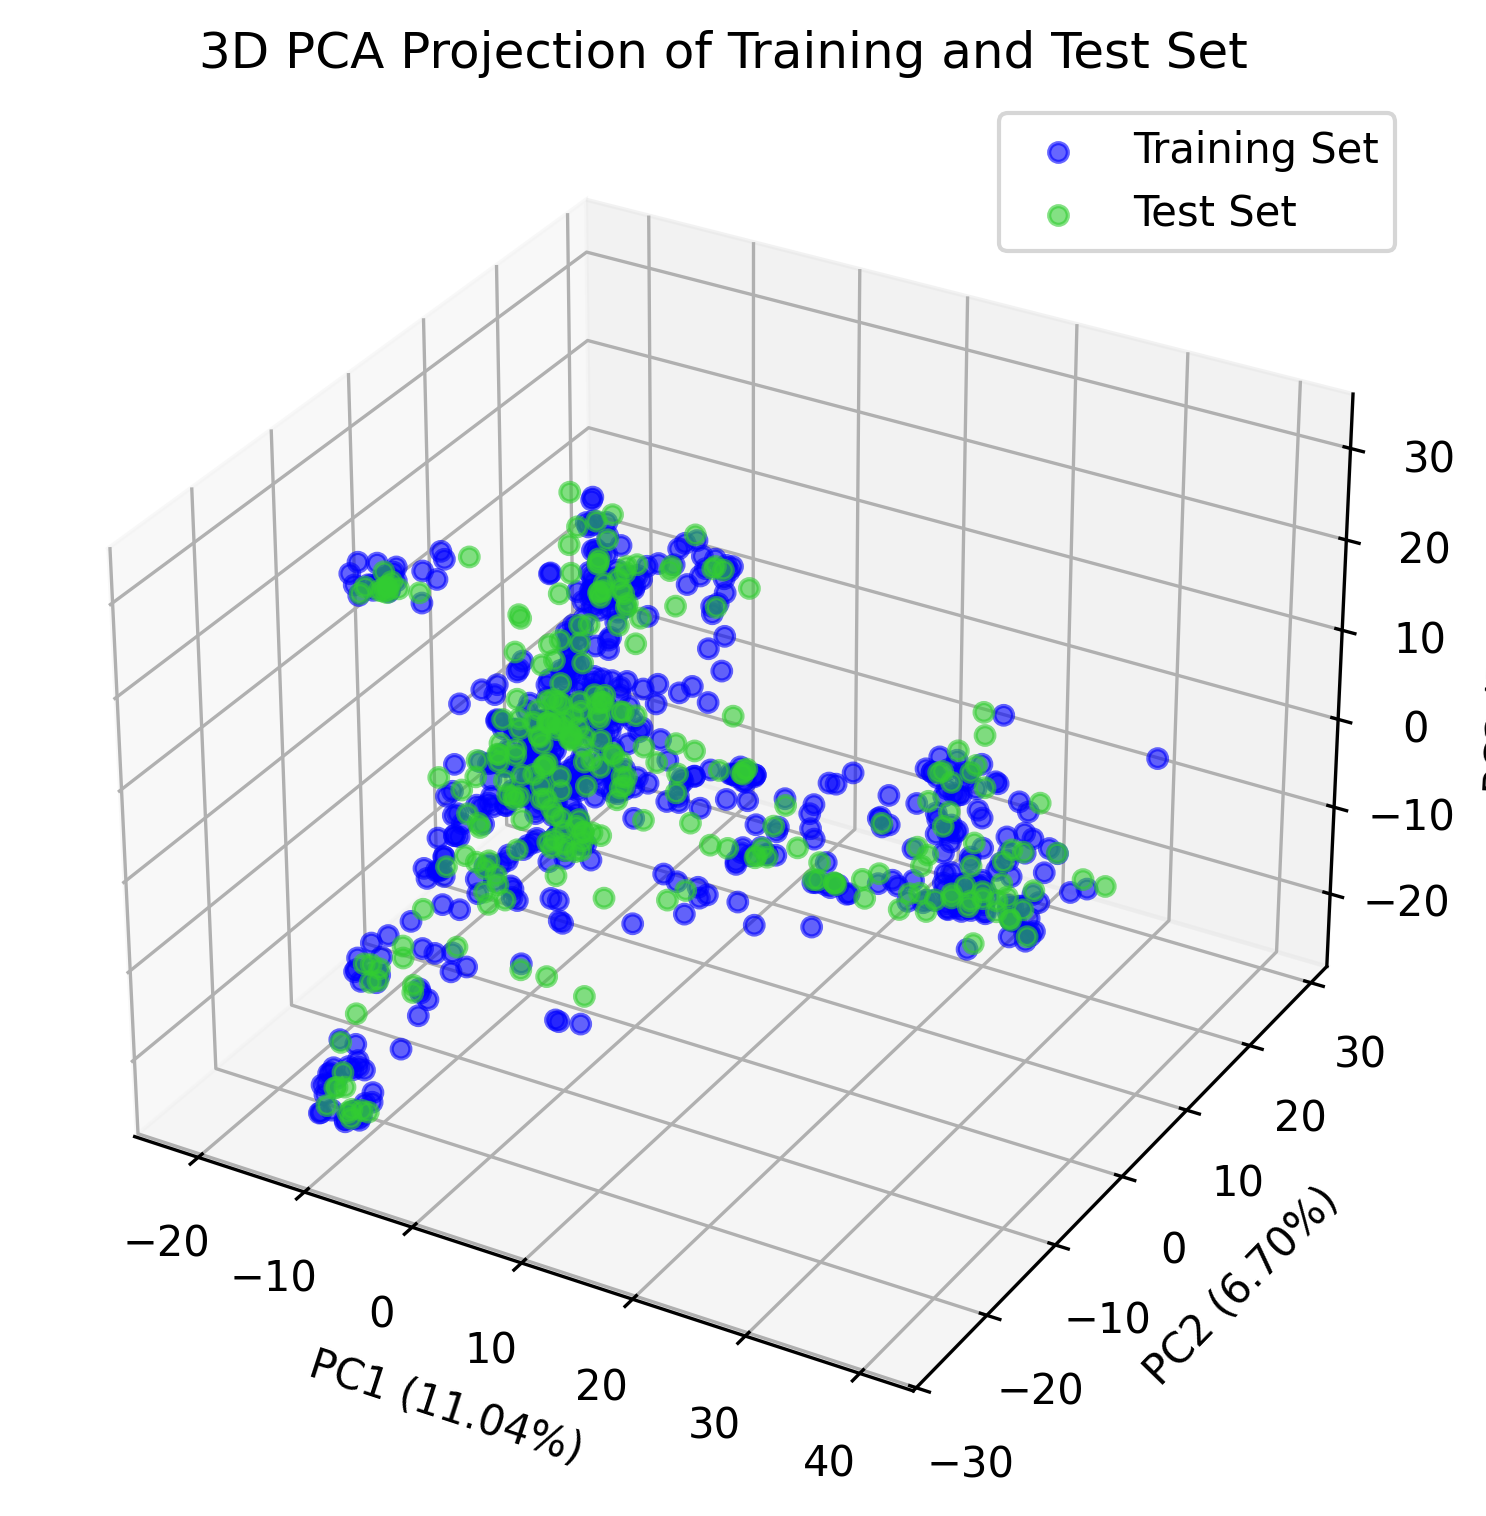

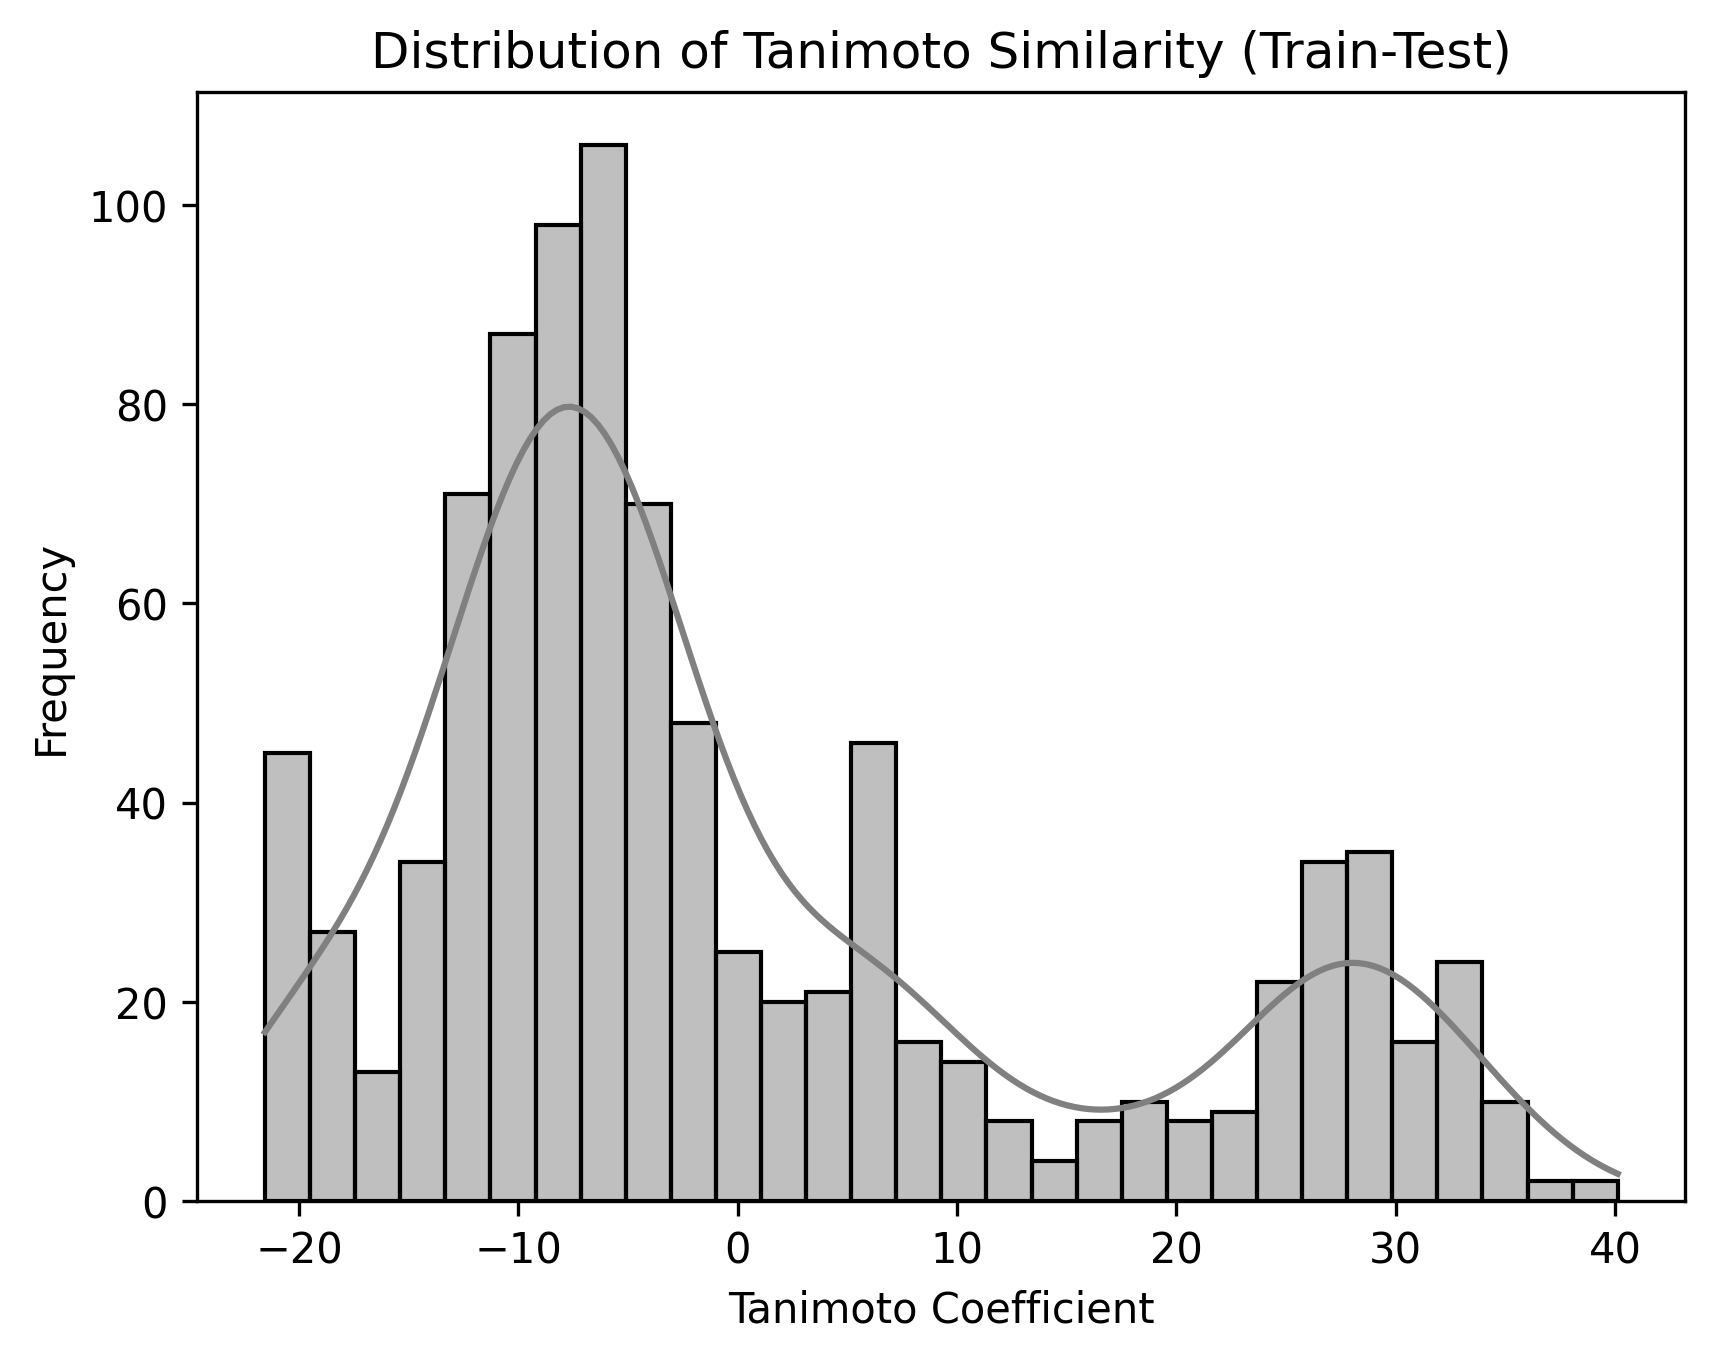

In [54]:
# Load Train & Test Datasets
X_train = pd.read_csv("X_train_clustered.csv")
X_test = pd.read_csv("X_test_clustered.csv")

# Standardize Features (Z-score normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler

# Handle inf and NaN values in X_train_scaled and X_test_scaled
X_train_scaled = np.nan_to_num(X_train_scaled)  # Replace NaN and inf with 0
X_test_scaled = np.nan_to_num(X_test_scaled)  # Replace NaN and inf with 0

# Apply PCA (Reduce to 3 Components for 3D Visualization)
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Convert to DataFrame for Plotting
train_pca_df = pd.DataFrame(X_train_pca, columns=["PC1", "PC2", "PC3"])
train_pca_df["Set"] = "Training Set"

test_pca_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2", "PC3"])
test_pca_df["Set"] = "Test Set"

pca_df = pd.concat([train_pca_df, test_pca_df])

# **Plot 3D PCA Scatter Plot**
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Scatter Plot with Different Colors for Train and Test
ax.scatter(train_pca_df["PC1"], train_pca_df["PC2"], train_pca_df["PC3"], c="blue", label="Training Set", alpha=0.6)
ax.scatter(test_pca_df["PC1"], test_pca_df["PC2"], test_pca_df["PC3"], c="limegreen", label="Test Set", alpha=0.6)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)")
ax.set_title("3D PCA Projection of Training and Test Set")
ax.legend()
plt.savefig("PCA_Train_Test_3D.jpeg", dpi=300)
plt.show()

# Plot Histogram of Tanimoto Similarity
sns.histplot(pca_df["PC1"], bins=30, kde=True, color="gray")
plt.xlabel("Tanimoto Coefficient")
plt.ylabel("Frequency")
plt.title("Distribution of Tanimoto Similarity (Train-Test)")
plt.savefig("Tanimoto_Similarity_after_spliiting.jpeg", dpi=300)
plt.show()


#Top Feature Selection (Top 15 & Top 30 Features)

SelectKBest(mutual_info_classif) was used to rank features based on their ability to predict the target variable (active/inactive class).  Features with the highest MI scores were selected these are the ones that provide the most information about the activity class.
A balance between fingerprints and physicochemical descriptors was ensured by separately selecting top-ranked features from each category.

In [55]:
#cross check number features in the training set
df = pd.read_csv("/content/X_train_clustered.csv")  # Replace with actual dataset filename
print("Total Features in Dataset:", df.shape[1])  # Should be 2110
print("\n First 10 Columns:", df.columns[:10].tolist())  # Check descriptor names

Total Features in Dataset: 2110

 First 10 Columns: ['AD2D4', 'AD2D12', 'AD2D13', 'AD2D82', 'AD2D91', 'AD2D92', 'AD2D93', 'AD2D102', 'AD2D169', 'AD2D170']


Select top 5 features from each of the 14 descriptor and fingerprint types, resulting in a total of top 70 features (5 × 14). This step will ensure that importance is given to all the 14 types features.

In [56]:
# **Step 1: Load Data**
X_train = pd.read_csv("X_train_clustered.csv")
X_test = pd.read_csv("X_test_clustered.csv")
y_train = pd.read_csv("y_train_clustered.csv").squeeze()
y_train_clustered = pd.read_csv("y_train_clustered.csv").squeeze()

# **Step 2: Identify RDKit Descriptors**
known_prefixes = ["AD2D", "APC2", "EStateFP", "ExtFP", "GraphFP", "KRFPC", "KRFP",
                  "MACCSFP", "PubchemFP", "SubFPC", "SubFP", "FP_", "X_and_Y"]

rdkit_columns = [col for col in X_train.columns if not any(col.startswith(prefix) for prefix in known_prefixes)]

# **Step 3: Rename RDKit Descriptor Columns**
rename_rdkit = {col: f"RD_{col}" for col in rdkit_columns}
X_train = X_train.rename(columns=rename_rdkit)
X_test = X_test.rename(columns=rename_rdkit)

# **Step 4: Define Feature Categories**
descriptor_types = {
    "AtomPairs2DCount": [col for col in X_train.columns if col.startswith("AD2D")],
    "AtomPairs2D": [col for col in X_train.columns if col.startswith("APC2")],
    "EState": [col for col in X_train.columns if col.startswith("EStateFP")],
    "CDKextended": [col for col in X_train.columns if col.startswith("ExtFP")],
    "CDKgraphonly": [col for col in X_train.columns if col.startswith("GraphFP")],
    "KlekotaRothCount": [col for col in X_train.columns if col.startswith("KRFPC")],
    "KlekotaRoth": [col for col in X_train.columns if col.startswith("KRFP")],
    "MACCS": [col for col in X_train.columns if col.startswith("MACCSFP")],
    "PubChem": [col for col in X_train.columns if col.startswith("PubchemFP")],
    "SubstructureCount": [col for col in X_train.columns if col.startswith("SubFPC")],
    "Substructure": [col for col in X_train.columns if col.startswith("SubFP")],
    "Morgan": [col for col in X_train.columns if col.startswith("FP_")],
    "Rdkit": [col for col in X_train.columns if col.startswith("RD_")],
}

# **Step 5: Feature Selection Function**
def select_top_k_features(X_train, y_train, X_test, feature_list, k):
    """ Selects top 'k' features using mutual information. """
    if len(feature_list) == 0:
        return pd.DataFrame(), pd.DataFrame(), []

    X_subset_train = X_train[feature_list]
    X_subset_test = X_test[feature_list]

    # If available features < k, select all
    k = min(k, X_subset_train.shape[1])

    kBest = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = kBest.fit_transform(X_subset_train, y_train)
    X_test_selected = kBest.transform(X_subset_test)

    selected_features = np.array(feature_list)[kBest.get_support()]

    return (pd.DataFrame(X_train_selected, columns=selected_features),
            pd.DataFrame(X_test_selected, columns=selected_features),
            selected_features)

# **Step 6: Select Top 70 Features (Minimum 5 from Each Type)**
selected_feature_names = []
X_train_selected_list = []
X_test_selected_list = []
remaining_slots = 70

for desc_type, feature_list in descriptor_types.items():
    if len(feature_list) > 0:
        X_train_selected, X_test_selected, selected_features = select_top_k_features(X_train, y_train, X_test, feature_list, k=5)
        X_train_selected_list.append(X_train_selected)
        X_test_selected_list.append(X_test_selected)
        selected_feature_names.extend(selected_features)
        remaining_slots -= len(selected_features)

# **Step 7: Fill Remaining Slots Based on MI Score**
if remaining_slots > 0:
    all_features = list(X_train.columns)
    X_train_remaining, X_test_remaining, extra_features = select_top_k_features(X_train, y_train, X_test, all_features, k=remaining_slots)

    X_train_selected_list.append(X_train_remaining)
    X_test_selected_list.append(X_test_remaining)
    selected_feature_names.extend(extra_features)

# **Step 8: Merge Selected Features**
X_train_final = pd.concat(X_train_selected_list, axis=1)
X_test_final = pd.concat(X_test_selected_list, axis=1)

# **Ensure Exactly 70 Features**
X_train_final = X_train_final.iloc[:, :70]
X_test_final = X_test_final.iloc[:, :70]
selected_feature_names = selected_feature_names[:70]

# **Step 9: Save Final Feature-Selected Datasets**
X_train_final.to_csv("X_train_top70.csv", index=False)
X_test_final.to_csv("X_test_top70.csv", index=False)

# **Step 10: Compute Mutual Information Scores for All 70 Features**
mi_scores = mutual_info_classif(X_train_final, y_train_clustered)

# **Step 11: Store MI Scores in a DataFrame & Save**
mi_scores_df = pd.DataFrame({
    "Feature": X_train_final.columns,
    "Mutual_Information": mi_scores
}).sort_values(by="Mutual_Information", ascending=False)

mi_scores_df.to_csv("mutual_information_scores.csv", index=False)

# **Step 12: Print Summary**
print("Feature selection completed with at least 5 features per descriptor type and exactly 70 total.")
print(f"Final dataset shape: {X_train_final.shape}")
print("\nMutual information scores calculated and saved to 'mutual_information_scores.csv'.")
print(mi_scores_df.head(10))  # Display top 10 features

# **Step 13: Save Selected Features List**
pd.DataFrame({"Feature": selected_feature_names}).to_csv("selected_top70_features.csv", index=False)
print("\nSelected Features Saved in 'selected_top70_features.csv'")


Feature selection completed with at least 5 features per descriptor type and exactly 70 total.
Final dataset shape: (652, 70)

Mutual information scores calculated and saved to 'mutual_information_scores.csv'.
           Feature  Mutual_Information
66      APC2D2_C_S            0.087544
30         KRFP298            0.073532
68  RD_EState_VSA8            0.071625
64  RD_EState_VSA8            0.063759
67   RD_SlogP_VSA8            0.061822
62    RD_SMR_VSA10            0.060894
60    RD_PEOE_VSA1            0.058522
6       APC2D2_C_S            0.058268
33        KRFPC298            0.057159
31        KRFP3659            0.057033

Selected Features Saved in 'selected_top70_features.csv'


Select Top 15 & Top 30 Features Based on Mutual Information Score

In [57]:
# **Step 1: Load MI Scores**
mi_scores_df = pd.read_csv("mutual_information_scores.csv")

# **Step 2: Select the Top 15 and Top 30 Features**
top_15_features = mi_scores_df.head(15)["Feature"].tolist()
top_30_features = mi_scores_df.head(30)["Feature"].tolist()

# **Step 3: Extract Corresponding Features from X_train**
X_train_top15 = X_train[top_15_features]
X_train_top30 = X_train[top_30_features]

# **Step 4: Save Final Feature-Selected Datasets**
X_train_top15.to_csv("X_train_top15.csv", index=False)
X_train_top30.to_csv("X_train_top30.csv", index=False)

# **Step 5: Print Summary**
print("Top 15 and Top 30 features selected based on Mutual Information Score.")
print(f"Top 15 feature dataset shape: {X_train_top15.shape}")
print(f"Top 30 feature dataset shape: {X_train_top30.shape}")

print("\nTop 15 Features:\n", top_15_features)
print("\nTop 30 Features:\n", top_30_features)


Top 15 and Top 30 features selected based on Mutual Information Score.
Top 15 feature dataset shape: (652, 15)
Top 30 feature dataset shape: (652, 30)

Top 15 Features:
 ['APC2D2_C_S', 'KRFP298', 'RD_EState_VSA8', 'RD_EState_VSA8', 'RD_SlogP_VSA8', 'RD_SMR_VSA10', 'RD_PEOE_VSA1', 'APC2D2_C_S', 'KRFPC298', 'KRFP3659', 'KRFPC936', 'SubFPC274', 'SubFPC274', 'APC2D3_N_S', 'RD_SlogP_VSA8']

Top 30 Features:
 ['APC2D2_C_S', 'KRFP298', 'RD_EState_VSA8', 'RD_EState_VSA8', 'RD_SlogP_VSA8', 'RD_SMR_VSA10', 'RD_PEOE_VSA1', 'APC2D2_C_S', 'KRFPC298', 'KRFP3659', 'KRFPC936', 'SubFPC274', 'SubFPC274', 'APC2D3_N_S', 'RD_SlogP_VSA8', 'APC2D1_C_N', 'PubchemFP599', 'AD2D639', 'GraphFP278', 'RD_PEOE_VSA11', 'KRFPC298', 'APC2D7_C_S', 'SubFPC300', 'SubFPC295', 'APC2D1_C_N', 'KRFPC297', 'SubFPC300', 'APC2D4_C_O', 'ExtFP362', 'SubFPC3']


Plotting Top 30 features

<ipython-input-58-b58308b0e9c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30["Feature"], x=top_30["Mutual_Information"], palette="viridis")


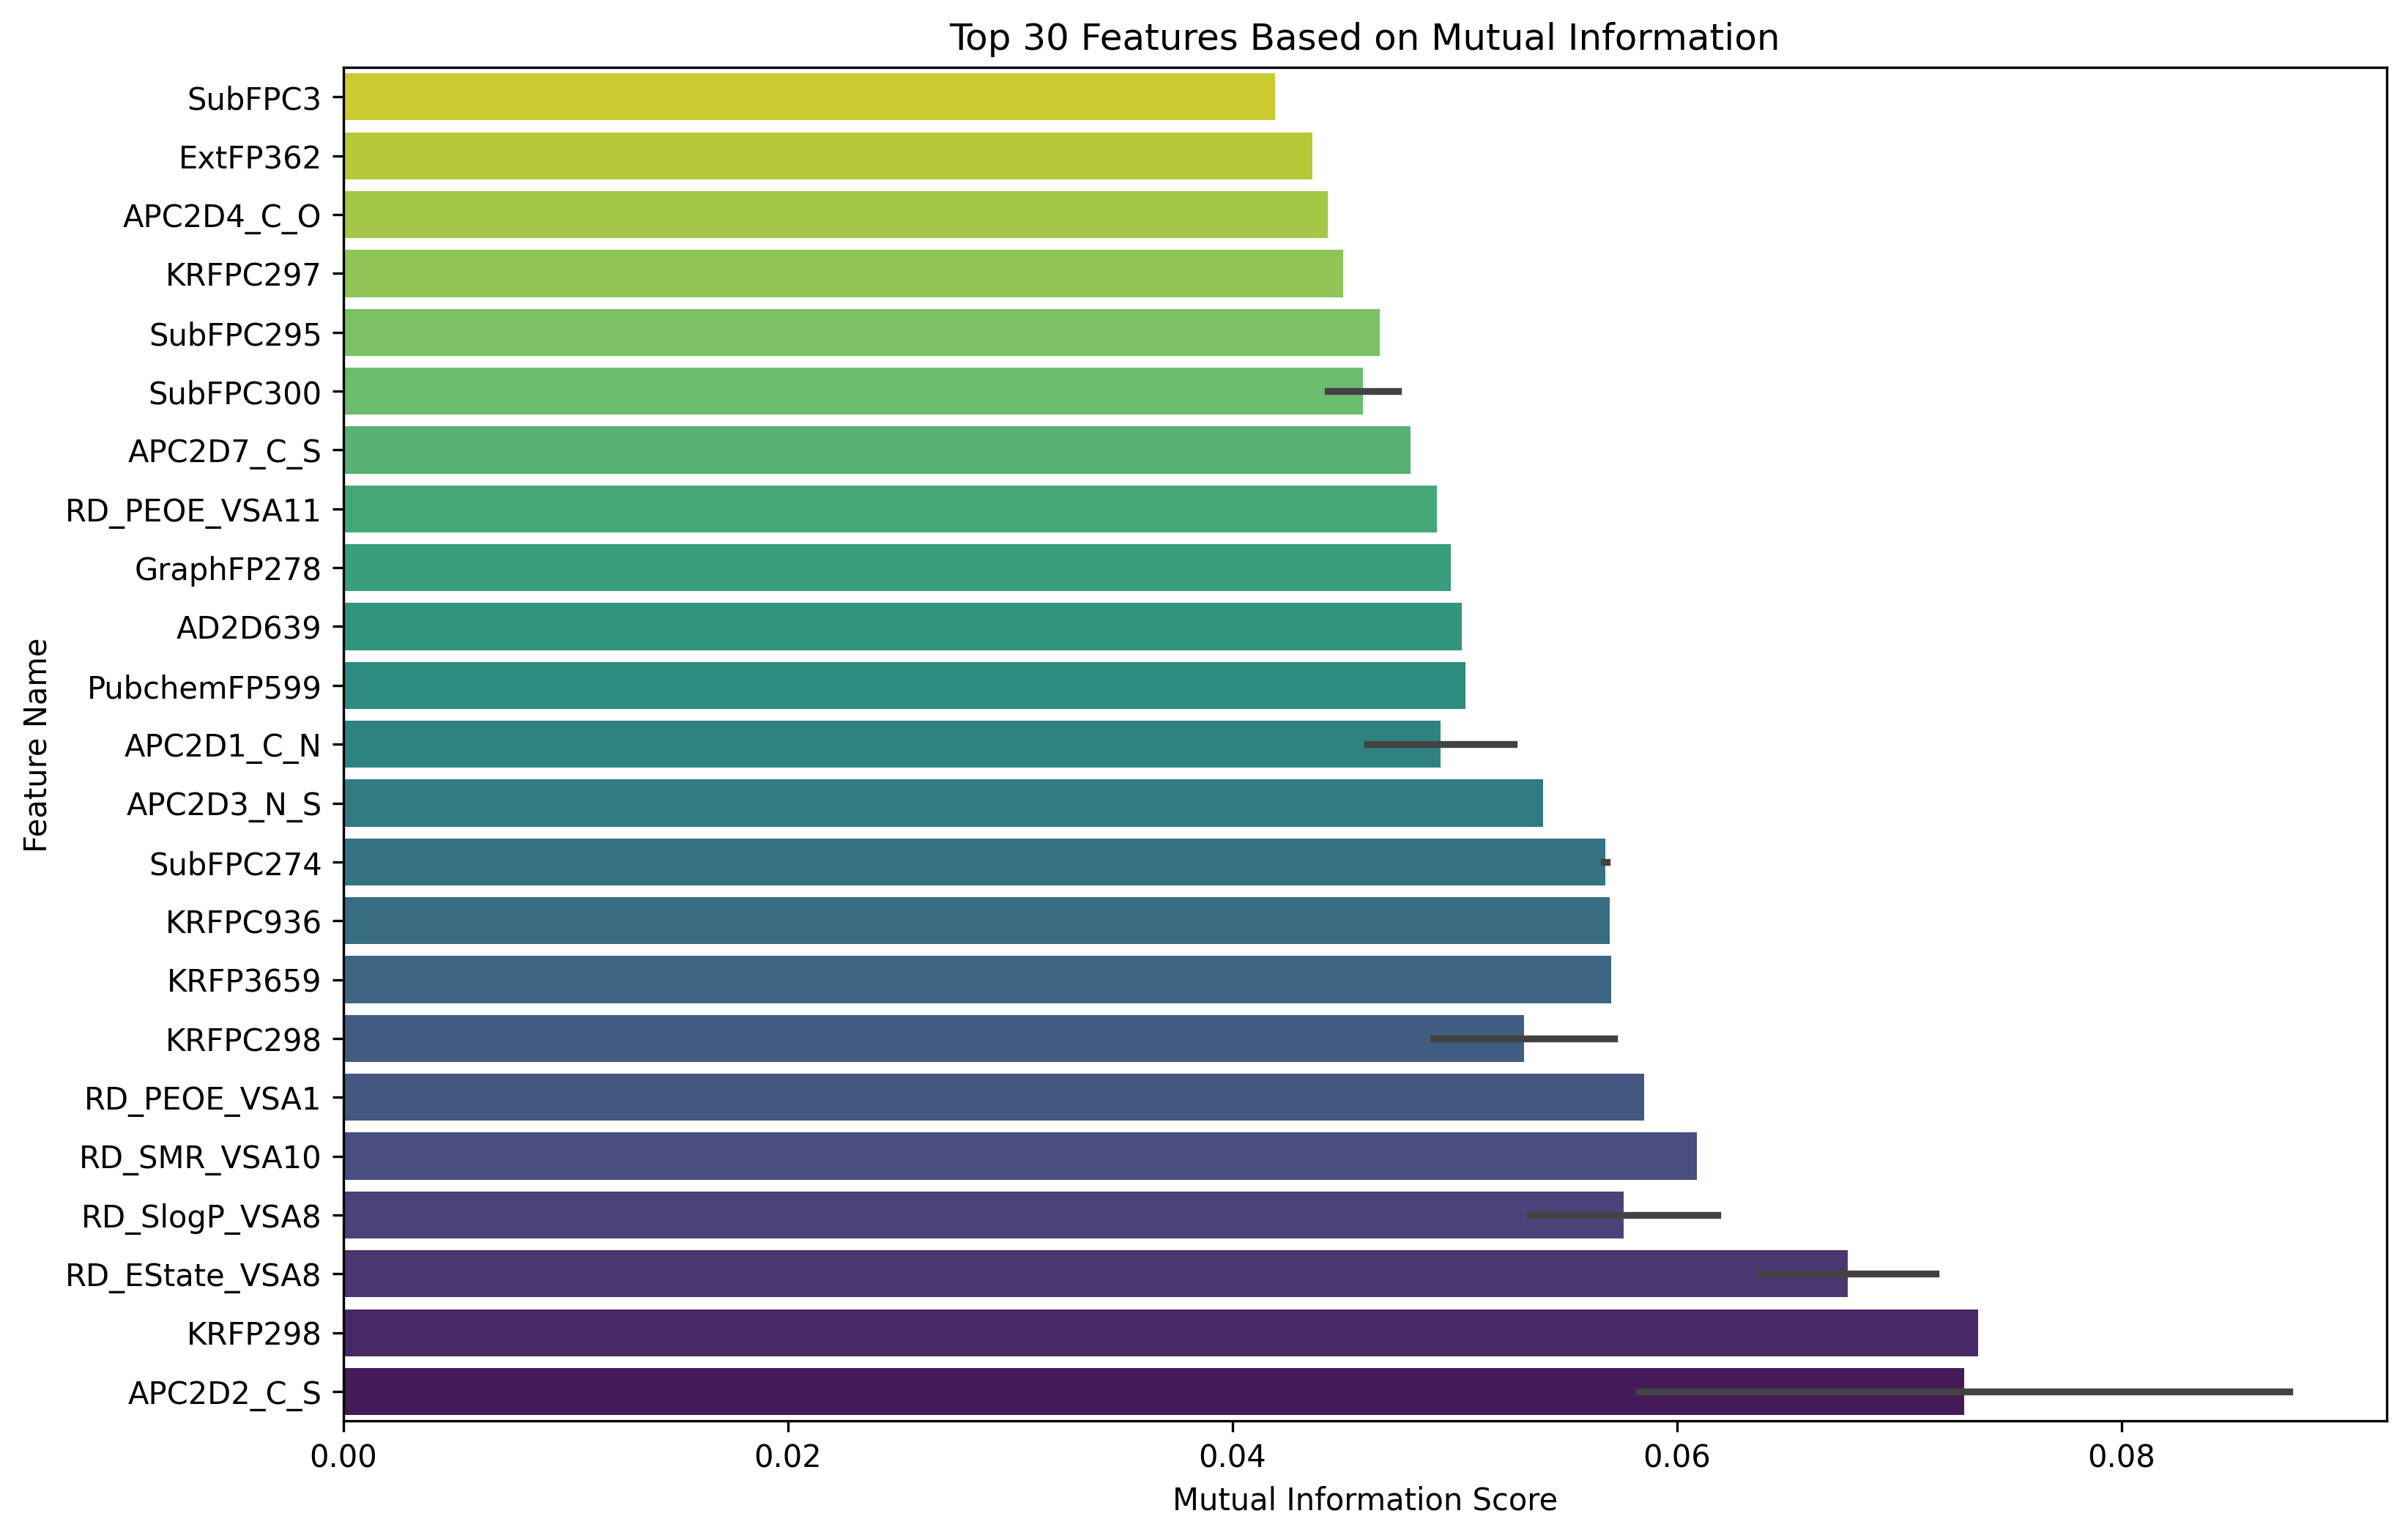

In [58]:
# **Step 1: Select Top 30 Features**
top_30 = mi_scores_df.head(30)

# **Step 2: Plot Top 30 Features**
plt.figure(figsize=(12, 8))
sns.barplot(y=top_30["Feature"], x=top_30["Mutual_Information"], palette="viridis")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature Name")
plt.title("Top 30 Features Based on Mutual Information")
plt.gca().invert_yaxis()
plt.savefig("Top30_features_based_on_mutul_infor_score.jpeg", dpi=300)
plt.show()

Re-adding Class colum in the top 15 and top 30 filtered features files

In [59]:
# **Step 1: Load y_train and y_test from saved CSV files**
y_train = pd.read_csv("y_train_clustered.csv")
y_test = pd.read_csv("y_test_clustered.csv")

# **Step 2: Ensure Index Alignment Between X and Y**
# If needed, reset index for proper merging
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_top15 = X_train_top15.reset_index(drop=True)
X_train_top30 = X_train_top30.reset_index(drop=True)
X_test_top15 = X_test_top15.reset_index(drop=True)
X_test_top30 = X_test_top30.reset_index(drop=True)

# **Step 3: Merge X and Y for Train & Test Sets**
train_top15_final = pd.concat([X_train_top15, y_train], axis=1)
train_top30_final = pd.concat([X_train_top30, y_train], axis=1)
test_top15_final = pd.concat([X_test_top15, y_test], axis=1)
test_top30_final = pd.concat([X_test_top30, y_test], axis=1)

# **Step 4: Save Final Merged Datasets**
train_top15_final.to_csv("train_top15_final.csv", index=False)
train_top30_final.to_csv("train_top30_final.csv", index=False)
test_top15_final.to_csv("test_top15_final.csv", index=False)
test_top30_final.to_csv("test_top30_final.csv", index=False)

# **Step 5: Output Summary**
print("✅ Merged feature-selected datasets with Y-variable.")
print(f"🔹 Final Train (Top 15 Features) Shape: {train_top15_final.shape}")
print(f"🔹 Final Train (Top 30 Features) Shape: {train_top30_final.shape}")
print(f"🔹 Final Test (Top 15 Features) Shape: {test_top15_final.shape}")
print(f"🔹 Final Test (Top 30 Features) Shape: {test_top30_final.shape}")


✅ Merged feature-selected datasets with Y-variable.
🔹 Final Train (Top 15 Features) Shape: (652, 16)
🔹 Final Train (Top 30 Features) Shape: (652, 31)
🔹 Final Test (Top 15 Features) Shape: (281, 16)
🔹 Final Test (Top 30 Features) Shape: (281, 31)


In [60]:
! zip SIRT1_features_selected.zip *.csv *.jpeg

  adding: AtomPairs2DCount.csv (deflated 97%)
  adding: AtomPairs2D.csv (deflated 98%)
  adding: CDKextended.csv (deflated 91%)
  adding: CDKgraphonly.csv (deflated 94%)
  adding: EState.csv (deflated 95%)
  adding: KlekotaRothCount.csv (deflated 99%)
  adding: KlekotaRoth.csv (deflated 99%)
  adding: MACCS.csv (deflated 94%)
  adding: merged_descriptors.csv (deflated 89%)
  adding: merged_descriptors_with_Name_Class.csv (deflated 89%)
  adding: Modified_molecules_with_morganfingerprints.csv (deflated 98%)
  adding: mutual_information_scores.csv (deflated 53%)
  adding: PCA_transformed_data.csv (deflated 61%)
  adding: processed_AtomPairs2DCount.csv (deflated 94%)
  adding: processed_AtomPairs2D.csv (deflated 94%)
  adding: processed_CDKextended.csv (deflated 92%)
  adding: processed_CDKgraphonly.csv (deflated 94%)
  adding: processed_EState.csv (deflated 93%)
  adding: processed_KlekotaRothCount.csv (deflated 96%)
  adding: processed_KlekotaRoth.csv (deflated 95%)
  adding: processed_

#In next part, we will be ML building of model using these top15 and top30 features datasets.